## 0. Load Project

### 0.1. Clone Project Repository (GitHub)

In [4]:
!git clone https://github.com/AHS-uni/speech-processing.git

Cloning into 'speech-processing'...
remote: Enumerating objects: 88, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 88 (delta 16), reused 84 (delta 12), pack-reused 0 (from 0)
Receiving objects: 100% (88/88), 10.18 MiB | 27.81 MiB/s, done.
Resolving deltas: 100% (16/16), done.


### 0.2. Clone Processed Dataset Files (HuggingFace)

In [12]:
!git lfs install
!git clone https://huggingface.co/datasets/AHS-uni/ljspeech-processed

Git LFS initialized.
Cloning into 'ljspeech-processed'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 8 (delta 0), reused 0 (delta 0), pack-reused 3 (from 1)
Unpacking objects: 100% (8/8), 1.84 KiB | 942.00 KiB/s, done.
Filtering content: 100% (3/3), 2.22 GiB | 31.41 MiB/s, done.


### 0.3. Move Processed Files to Correct Directory

In [13]:
!mv /content/ljspeech-processed/*.pt /content/speech-processing/data/preprocessed/

In [14]:
%cd /content/speech-processing

/content/speech-processing


## 1. Environment Setup

### 1.1. Load Config

In [17]:
from src.config import load_config
import pprint

cfg = load_config("config.yaml")
pprint.pprint(cfg)

{'batch_size': 32,
 'character_coverage': 1.0,
 'dataset_dir': 'data/LJSpeech',
 'hop_length': 256,
 'n_fft': 1024,
 'n_mels': 80,
 'preprocessed_dir': 'data/preprocessed',
 'splits_dir': 'data/splits',
 'stats_dir': 'data/stats',
 'tokenizer_dir': 'data/preprocessed/tokenizer',
 'train_ratio': 0.8,
 'val_ratio': 0.1,
 'vocab_size': 1000}


In [18]:
n_mels = cfg['n_mels']
vocab_size = cfg['vocab_size']
batch_size = cfg['batch_size']

## 2. Dataset and DataLoader

In [19]:
from src.dataset import LJSpeechDataset, collate_fn
from torch.utils.data import DataLoader

### 2.1. Instantiate Datasets

In [20]:
train_ds = LJSpeechDataset(split='train', cfg=cfg)
val_ds   = LJSpeechDataset(split='val',   cfg=cfg)
test_ds  = LJSpeechDataset(split='test',  cfg=cfg)

print(f"Train samples: {len(train_ds)}")
print(f"Val   samples: {len(val_ds)}")
print(f"Test  samples: {len(test_ds)}")

Train samples: 10480
Val   samples: 1310
Test  samples: 1310


### 2.2. Create DataLoaders

In [21]:
train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
)
val_loader = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
)

In [22]:
# Inspect one batch
batch = next(iter(train_loader))
print({
    'specs': batch['specs'].shape,
    'spec_lengths': batch['spec_lengths'][:5],
    'tokens': batch['tokens'].shape,
    'token_lengths': batch['token_lengths'][:5],
})

{'specs': torch.Size([32, 1, 80, 813]), 'spec_lengths': tensor([462, 526, 712, 788, 600]), 'tokens': torch.Size([32, 46]), 'token_lengths': tensor([23, 35, 38, 37, 37])}


## 3. Model Definition

In [23]:
import torch
from src.model import HybridASR

In [24]:
model = HybridASR(cfg)
# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters in HybridASR: {total_params:,}")

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Total parameters in HybridASR: 4,785,360


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


HybridASR(
  (subsampler): Sequential(
    (0): Conv2d(1, 256, kernel_size=(80, 3), stride=(1, 2), padding=(0, 1))
    (1): ReLU()
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ctc_head): Linear(in_features=256, out_features=1000, bias=True)
  (embedding): Embedding(1000, 256)
  (decoder): TransformerDecoder(
    (layers): ModuleLis

## 4. Sanity Checks

In [30]:
# Dummy inputs
T_dummy = 100
L_dummy = 20

dummy_specs  = torch.randn(batch_size, 1, n_mels, T_dummy, device=device)
# tokens in [0, vocab_size)
dummy_tokens = torch.randint(low=0, high=vocab_size, size=(batch_size, L_dummy), device=device)

### 4.1 Forward Pass: CTC-only

In [28]:
ctc_logits = model(dummy_specs)
print('CTC-only output shape:', ctc_logits.shape)

CTC-only output shape: torch.Size([50, 32, 1000])


### 4.3. Forward Pass: CTC + decoder

In [29]:
ctc_out, dec_logits = model(dummy_specs, tokens=dummy_tokens)
print('CTC output shape:', ctc_out.shape)
print('Decoder output shape:', dec_logits.shape)

CTC output shape: torch.Size([50, 32, 1000])
Decoder output shape: torch.Size([32, 20, 1000])


## 5. Visualizations

In [31]:
import matplotlib.pyplot as plt

### 5.1. Distribution of Spectrogram Lengths in a Batch

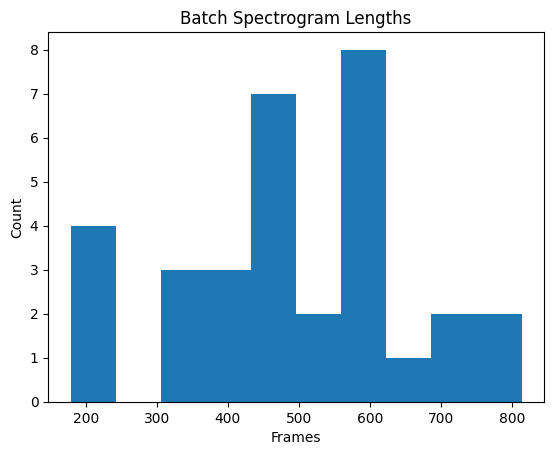

In [32]:
spec_lens = batch['spec_lengths'].cpu().numpy()
plt.hist(spec_lens, bins=10)
plt.title('Batch Spectrogram Lengths')
plt.xlabel('Frames'); plt.ylabel('Count')
plt.show()

### 5.2. Distribution of Token Lengths in a Batch

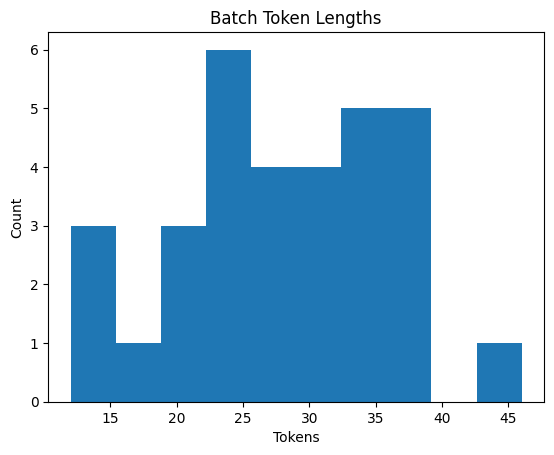

In [33]:
token_lens = batch['token_lengths'].cpu().numpy()
plt.hist(token_lens, bins=10)
plt.title('Batch Token Lengths')
plt.xlabel('Tokens'); plt.ylabel('Count')
plt.show()